In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy import units as u
from astropy.io import ascii
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic, Angle
from astropy.time import Time
from tqdm import tqdm

In [2]:
files = glob.glob('../IPTA_DR1/*/*.par')

In [3]:
RAs = []
DECs = []
Names = []
pmra = []
pmra_err = []
pmdec = []
pmdec_err = []
pepoch = []
posepoch = []
dmepoch = []
dm = []
coords = []

In [4]:
for file in files:
    d = {}
    with open(file) as f:
        for line in f:
            key = line.split()[0]
            value = line.split()[1]
            d[key] = value
            if key in ['RAJ', 'DECJ', 'PMRA', 'PMDEC', 'PX']:
                try:
                    err = line.split()[3]
                    d[key+'_ERR'] = err
                except:
                    print("this file is missing uncertainties \
on {0}: {1}".format(key, file))
                    d[key+'_ERR'] = 0.0
    
    try:
        ra = Angle(d['RAJ'], u.hourangle).to(u.deg)
        dec = Angle(d['DECJ'], u.degree)
        coord = SkyCoord(ra=ra, dec=dec, frame='icrs',
                         pm_ra_cosdec = float(d['PMRA'])*u.mas/u.yr,
                         pm_dec=float(d['PMDEC'])*u.mas/u.yr,
                         obstime=Time(float(d['POSEPOCH']), format='mjd'),
                         distance=1. * u.kpc) # HACK
        coords.append(coord)
        RAs.append(ra.value)
        DECs.append(dec.value)
        Names.append(d['PSRJ'])
        pmra.append(coord.pm_ra_cosdec.value)
        pmra_err.append(float(d['PMRA_ERR']))
        pmdec.append(coord.pm_dec.value)
        pmdec_err.append(float(d['PMDEC_ERR']))
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM'])
        
    except KeyError:
        lon = float(d['ELONG'])*u.deg
        lat = float(d['ELAT'])*u.deg
        coord = SkyCoord(l=lon, b=lat, frame='galactic',
                             pm_l_cosb = float(d['PMELONG'])*u.mas/u.yr, 
                             pm_b=float(d['PMELAT'])*u.mas/u.yr,
                             obstime=Time(float(d['POSEPOCH']), format='mjd'),
                             distance=1. * u.kpc) # HACKITY HACK HACK
        icrscoord = coord.transform_to(ICRS)
        coords.append(icrscoord)
        print("this object has galactic coords: {0}".format(d['PSRJ']))
        RAs.append(icrscoord.ra.to(u.deg).value)
        DECs.append(icrscoord.dec.to(u.deg).value)
        Names.append(d['PSRJ'])
        pmra.append(icrscoord.pm_ra_cosdec.value)
        pmra_err.append(0.0) # TEMPORARY HACK
        pmdec.append(icrscoord.pm_dec.value)
        pmdec_err.append(0.0) # TEMPORARY HACK
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM']) 

this file is missing uncertainties on RAJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PX: ../IPTA_DR1/J0437-4715/J0437-4715.par
this object has galactic coords: J1022+1001
this file is missing uncertainties on RAJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PX: ../IPTA_DR1/J1643-1224/J1643-1224.par


### a bad case: J1910+1256

In [19]:
ind = np.where(np.array(Names) == 'J1910+1256')[0][0]

In [20]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [21]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.54042259, 12.9404131, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (0.25061013, -6.93472136)>

In [22]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=287.5407215 * u.degree, 
                             dec=12.94037301 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.672057539 *u.mas/u.yr,
                         pm_dec= -5.449112763 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.576369178
gaia_dec_err = 0.623526292
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.5407215, 12.94037301, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.67205754, -5.44911276)>

In [23]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

1.0526847597792082

In [24]:
N = 100
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [40]:
np.min(ipta_ras)

287.54042248890147

In [38]:
np.std(gaia_ras)

0.00016668193966642284

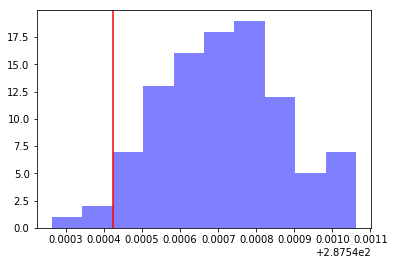

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(gaia_ras, alpha=0.5, color='blue')
plt.axvline(np.median(ipta_ras), color='red')

#ax.hist(ipta_ras, alpha=0.5, color='red')
#ax.set_xlim([np.min(ipta_ras),np.max(ipta_ras)+0.00001])

(12.940401391187363, 12.940403738064273)

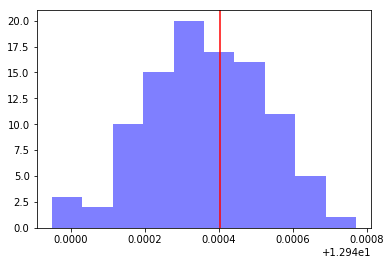

In [48]:
#plt.hist(ipta_decs, alpha=0.5, color='red')
plt.axvline(np.median(ipta_decs), color='red')
plt.hist(gaia_decs, alpha=0.5, color='blue')
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])

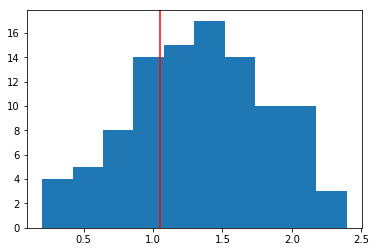

In [11]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

## a not-so-bad disagreement case: J1012+5307

In [50]:
ind = np.where(np.array(Names) == 'J1012+5307')[0][0]

In [51]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [52]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.13932304, 53.1173056, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.62371226, -25.45880892)>

In [53]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=153.1393303 * u.degree, 
                             dec=53.11726303 * u.degree, frame='icrs',
                         pm_ra_cosdec = 2.976959985 *u.mas/u.yr,
                         pm_dec= -26.94384758 *u.mas/u.yr,
                         obstime= gaia_time,
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.241174616
gaia_dec_err = 0.302546482
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.1393303, 53.11726303, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.97695999, -26.94384758)>

In [54]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.012298049411488533

In [55]:
N = 100
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


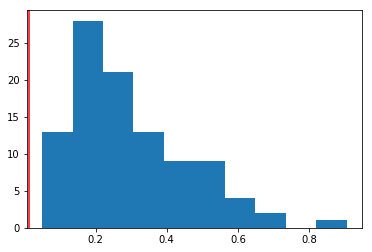

In [56]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

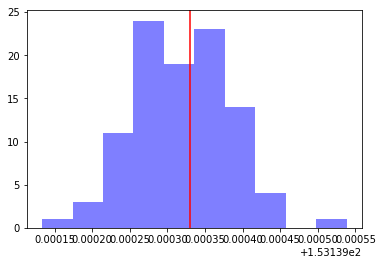

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(gaia_ras, alpha=0.5, color='blue')
plt.axvline(np.median(ipta_ras), color='red')

#ax.hist(ipta_ras, alpha=0.5, color='red')
#ax.set_xlim([np.min(ipta_ras),np.max(ipta_ras)+0.00001])

(53.117266299183584, 53.11726654308136)

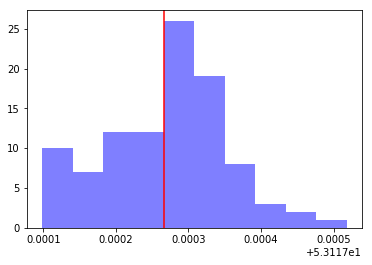

In [58]:
#plt.hist(ipta_decs, alpha=0.5, color='red')
plt.axvline(np.median(ipta_decs), color='red')
plt.hist(gaia_decs, alpha=0.5, color='blue')
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])